<h1 style="text-align:center;"><u><b>Unstructured Data Analytics - Assignment 3<b></u></h1>
Team Members:
Sukhada Virkar, Ruizhi Ding, Abhiram Iyengar, Anshul Joshi, Akhil Sourav

###TASK A

In [ ]:
!pip install instaloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 643.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for instaloader: filename=instaloader-4.13.2-py3-none-any.whl size=67324 sha256=b4a183efaf7851fa89dec3cd94e161abfa8044290daeaed3e5a6ab8fd3f5ab68
  Stored in directory: /root/.cache/pip/wheels/28/58/77/22970d6e07a2e97576e2d645e111b2c095a0acba6386356803
Successfully built instaloader


Using Puma as the brand

In [ ]:
import instaloader
import pandas as pd

# Initialize Instaloader
L = instaloader.Instaloader()

# Log in to Instagram (if needed)
L.login('abhiram_.i', 'abhiy2jram')

# Scrape Puma's profile
profile = instaloader.Profile.from_username(L.context, 'puma')

# Create lists to store scraped data
image_urls = []
post_captions = []
likes = []

# Fetch the first 500 posts
for post in profile.get_posts():
    if len(image_urls) >= 500:  # Limit to 500 posts
        break
    image_urls.append(post.url)
    post_captions.append(post.caption)
    likes.append(post.likes)

# Create a pandas DataFrame
data = pd.DataFrame({
    'image_url': image_urls,
    'post_caption': post_captions,
    'likes': likes
})

# Save the data to a CSV file for further use
data.to_csv('puma_instagram_posts.csv', index=False)

# Display the first few rows of the dataset
print(data.head())


                                           image_url  \
0  https://scontent-tpe1-1.cdninstagram.com/v/t51...   
1  https://scontent-tpe1-1.cdninstagram.com/v/t51...   
2  https://scontent-tpe1-1.cdninstagram.com/v/t51...   
3  https://scontent-tpe1-1.cdninstagram.com/v/t51...   
4  https://scontent-tpe1-1.cdninstagram.com/v/t51...   

                                        post_caption    likes  
0  A CHIP FOR #STEWYORKCITY 🗽\n\nCongratulations ...    15010  
1                     HE IS BACKKKKKKKK 🥹💙 @neymarjr  1078407  
2  Competitiveness. Dominance. Versatility. \n\n@...     2327  
3  The Avanti by @badgalriri in Warm White and Cl...    26981  
4                                   Fastest family 😘   320488  


###TASK B

In [ ]:
import requests
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
import pandas as pd
import torch

# Load the ViT model and processor for image classification
model_name = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

def generate_image_labels_from_csv(image_link_column, limit):
    """
    Reads a CSV file, generates labels for images from URLs, and saves the results.

    Parameters:
    - csv_file (str): The path to the CSV file containing image URLs.
    - image_link_column (str): The column name containing image URLs.
    - limit (int): The number of images to process.
    """
    # Load the CSV file into a DataFrame
    dataframe = pd.read_csv('puma_instagram_posts.csv')

    # Create a new column for image labels
    dataframe['Image Label'] = ''

    for index, img_url in enumerate(dataframe[image_link_column]):
        if index >= limit:
            break  # Exit the loop once the limit is reached

        try:
            # Fetch the image from the URL
            response = requests.get(img_url, stream=True)
            response.raise_for_status()  # Raise an error for bad status codes

            # Open the image and convert it to RGB
            raw_image = Image.open(response.raw).convert('RGB')

            # Prepare the image for the model
            inputs = processor(raw_image, return_tensors="pt")

            # Generate the labels
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            # Get the top label
            top_probs, top_indices = probs.topk(1)
            label = model.config.id2label[top_indices[0].item()]
            confidence = top_probs[0].item()

            # Assign the label to the 'Image Label' column using .loc
            dataframe.loc[index, 'Image Label'] = f"{label} ({confidence:.2f})"

            # Print the generated label
            print(f"Label for Image {index + 1}: {label} ({confidence:.2f})")

        except requests.exceptions.RequestException as req_err:
            print(f"Request error for Image {index + 1}: {req_err}")
            dataframe.loc[index, 'Image Label'] = 'Error fetching image'

        except Exception as e:
            print(f"An error occurred for Image {index + 1}: {e}")
            dataframe.loc[index, 'Image Label'] = 'Error processing image'

    # Save the DataFrame with labels to a new CSV file
    output_file = 'labeled_output_insta.csv'
    dataframe.to_csv(output_file, index=False)
    print(f"Image labels saved to {output_file}")


image_link_column = 'image_url'  # The column containing image URLs
generate_image_labels_from_csv(image_link_column, limit=500)  # Adjust limit as needed

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Label for Image 1: racket, racquet (0.19)
Label for Image 2: bathing cap, swimming cap (0.08)
Label for Image 3: basketball (0.81)
Label for Image 4: Loafer (0.31)
Label for Image 5: suit, suit of clothes (0.50)
Label for Image 6: running shoe (0.82)
Label for Image 7: jersey, T-shirt, tee shirt (0.77)
Label for Image 8: suit, suit of clothes (0.91)
Label for Image 9: mousetrap (0.15)
Label for Image 10: theater curtain, theatre curtain (0.21)
Label for Image 11: swab, swob, mop (0.14)
Label for Image 12: jersey, T-shirt, tee shirt (0.78)
Label for Image 13: racket, racquet (0.37)
Label for Image 14: balance beam, beam (0.15)
Label for Image 15: maillot (0.27)
Label for Image 16: maillot (0.27)
Label for Image 17: maillot (0.09)
Label for Image 18: basketball (0.17)
Label for Image 19: horizontal bar, high bar (0.79)
Label for Image 20: stage (0.15)
Label for Image 21: scoreboard (0.64)
Label for Image 22: pickelhaube (0.88)
Label for Image 23: pole (0.15)
Label for Image 24: cinema, m

###Task C

In [ ]:
import pandas as pd

labeled_output_df = pd.read_csv('labeled_output_insta.csv')

median_likes = labeled_output_df['likes'].median()

labeled_output_df['binary'] = (labeled_output_df['likes'] > median_likes).astype(int)

print(labeled_output_df[['image_url', 'likes', 'binary']].head())

labeled_output_df.to_csv('labeled_output_with_binary.csv', index=False)

labeled_output_df.head()

                                           image_url    likes  binary
0  https://scontent-tpe1-1.cdninstagram.com/v/t51...    15010       0
1  https://scontent-tpe1-1.cdninstagram.com/v/t51...  1078407       1
2  https://scontent-tpe1-1.cdninstagram.com/v/t51...     2327       0
3  https://scontent-tpe1-1.cdninstagram.com/v/t51...    26981       1
4  https://scontent-tpe1-1.cdninstagram.com/v/t51...   320488       1


,image_url,post_caption,likes,Image Label,binary
0,https://scontent-tpe1-1.cdninstagram.com/v/t51...,A CHIP FOR #STEWYORKCITY 🗽\n\nCongratulations ...,15010,"racket, racquet (0.19)",0
1,https://scontent-tpe1-1.cdninstagram.com/v/t51...,HE IS BACKKKKKKKK 🥹💙 @neymarjr,1078407,"bathing cap, swimming cap (0.08)",1
2,https://scontent-tpe1-1.cdninstagram.com/v/t51...,Competitiveness. Dominance. Versatility. \n\n@...,2327,basketball (0.81),0
3,https://scontent-tpe1-1.cdninstagram.com/v/t51...,The Avanti by @badgalriri in Warm White and Cl...,26981,Loafer (0.31),1
4,https://scontent-tpe1-1.cdninstagram.com/v/t51...,Fastest family 😘,320488,"suit, suit of clothes (0.50)",1


###Task D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Logistic Regression with Image Labels
Confusion Matrix:
 [[0.36363636 0.63636364]
 [0.28888889 0.71111111]]
Accuracy: 0.52


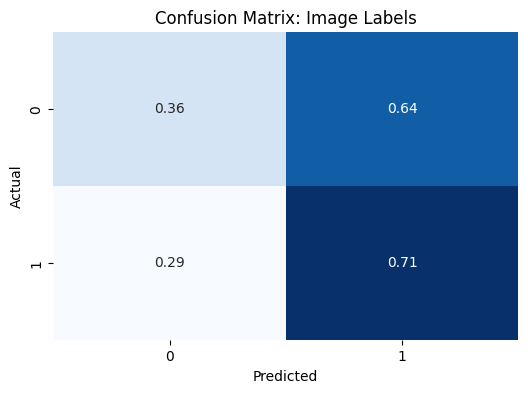


Logistic Regression with Post Captions
Confusion Matrix:
 [[0.56363636 0.43636364]
 [0.22222222 0.77777778]]
Accuracy: 0.66


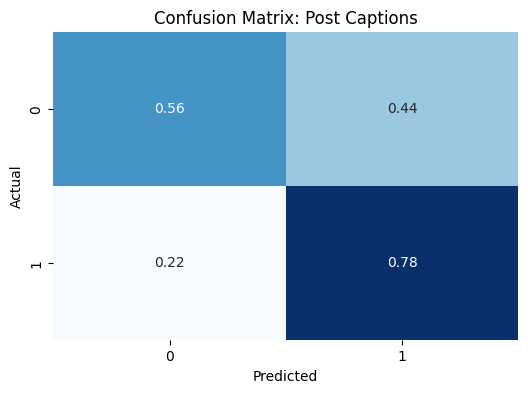


Logistic Regression with Combined Image Labels and Post Captions
Confusion Matrix:
 [[0.69090909 0.30909091]
 [0.33333333 0.66666667]]
Accuracy: 0.68


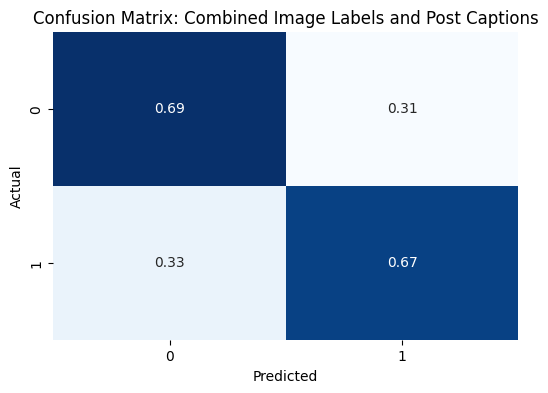

In [ ]:
# Logistic Regression Analysis
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Load labeled data
data = pd.read_csv('labeled_output_with_binary.csv')

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stemmer and stopwords for text preprocessing
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

# Preprocess text columns
data['post_caption'] = data['post_caption'].fillna('').apply(preprocess_text)
data['Image Label'] = data['Image Label'].fillna('').apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95, stop_words="english", use_idf=True)

# Logistic Regression with `Image Label` as independent variable
X_image_labels = tfidf_vectorizer.fit_transform(data['Image Label'])
Y = data['binary']

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_image_labels, Y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

# Make predictions and evaluate
Y_pred = model.predict(X_test)
accuracy_image_labels = accuracy_score(Y_test, Y_pred)
conf_matrix_labels = confusion_matrix(Y_test, Y_pred, normalize='true')

print("Logistic Regression with Image Labels")
print("Confusion Matrix:\n", conf_matrix_labels)
print("Accuracy:", accuracy_image_labels)

# Plot confusion matrix for Image Labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_labels, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Image Labels')
plt.show()

# Logistic Regression with `post_caption` as independent variable
X_post_captions = tfidf_vectorizer.fit_transform(data['post_caption'])

# Train-test split
X_train_cap, X_test_cap, Y_train_cap, Y_test_cap = train_test_split(X_post_captions, Y, test_size=0.2, random_state=42)

# Train logistic regression model
model.fit(X_train_cap, Y_train_cap)

# Make predictions and evaluate
Y_pred_cap = model.predict(X_test_cap)
accuracy_post_caption = accuracy_score(Y_test_cap, Y_pred_cap)
conf_matrix_captions = confusion_matrix(Y_test_cap, Y_pred_cap, normalize='true')

print("\nLogistic Regression with Post Captions")
print("Confusion Matrix:\n", conf_matrix_captions)
print("Accuracy:", accuracy_post_caption)

# Plot confusion matrix for Post Captions
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_captions, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Post Captions')
plt.show()

# Logistic Regression with combined `Image Label` and `post_caption` as independent variables
X_combined = hstack([X_image_labels, X_post_captions])

# Train-test split
X_train_comb, X_test_comb, Y_train_comb, Y_test_comb = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

# Train logistic regression model
model.fit(X_train_comb, Y_train_comb)

# Make predictions and evaluate
Y_pred_comb = model.predict(X_test_comb)
accuracy_combined = accuracy_score(Y_test_comb, Y_pred_comb)
conf_matrix_combined = confusion_matrix(Y_test_comb, Y_pred_comb, normalize='true')

print("\nLogistic Regression with Combined Image Labels and Post Captions")
print("Confusion Matrix:\n", conf_matrix_combined)
print("Accuracy:", accuracy_combined)

# Plot confusion matrix for Combined Features
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_combined, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Combined Image Labels and Post Captions')
plt.show()

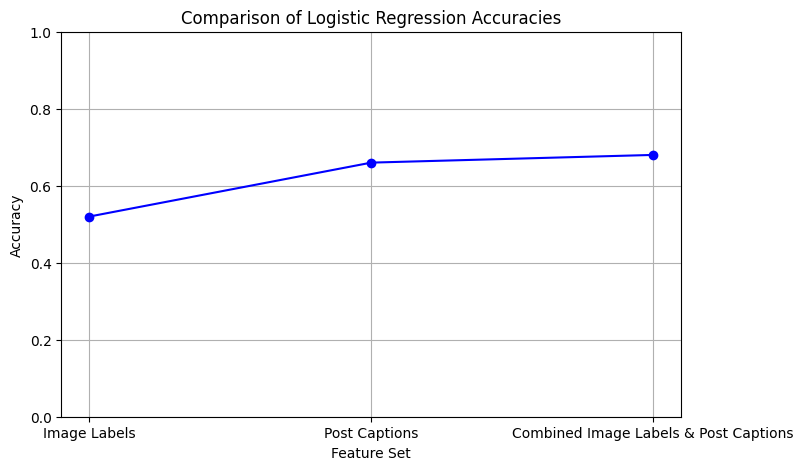

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values from the logistic regression results
accuracies = [accuracy_image_labels, accuracy_post_caption, accuracy_combined]
labels = [
    "Image Labels",
    "Post Captions",
    "Combined Image Labels & Post Captions"
]

# Plotting the accuracies
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Feature Set")
plt.ylabel("Accuracy")
plt.title("Comparison of Logistic Regression Accuracies")
plt.ylim(0, 1)  # Set y-axis to 0-1 for better visualization of accuracies
plt.grid(True)

plt.show()


Conclusion from analysis:<br>
**Using Image Labels:** <br>The model using only image labels as features achieved an accuracy of 0.52. The confusion matrix indicates a significant amount of misclassification, especially for the "0" class (low engagement).<br>
**Using Post Captions:** <br>Using post captions as features, the model's accuracy improved to 0.66. This higher accuracy suggests that text-based post captions provide more informative signals for predicting engagement compared to image labels alone.<br>
**Using Combined Image Labels and Post Captions:** <br> Combining image labels and post captions further increased accuracy to 0.68. This slight improvement indicates that while both types of features contribute to the prediction, the captions play a more substantial role.<br><br>
Also, the confusion matrices across models show that the model tends to classify the "1" class (high engagement) more accurately than the "0" class. This could indicate an inherent imbalance or bias in the data or feature representation.

###TASK E

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import nltk

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
data = pd.read_csv('labeled_output_insta.csv')

# Preprocess text data
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = tokenizer.tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data['Image Label'].apply(preprocess_text)

# Create a TFIDF Vectorizer for the LDA model
vectorizer = TfidfVectorizer()
text_matrix = vectorizer.fit_transform(data['processed_text'])

# Set up the LDA model with an initial number of topics
num_topics = 5  # You can adjust this number based on evaluation
lda_model = LDA(n_components=num_topics, random_state=42)
lda_model.fit(text_matrix)

# Extract topic-word and document-topic distributions
topic_word_dist = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
doc_topic_dist = lda_model.transform(text_matrix)

# Add document-topic distributions to the DataFrame
topic_columns = [f'Topic_{i+1}' for i in range(num_topics)]
doc_topic_df = pd.DataFrame(doc_topic_dist, columns=topic_columns)
data = pd.concat([data, doc_topic_df], axis=1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Get feature names (vocabulary) from CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Number of top words to display per topic
top_n_words = 10

# Display top words for each topic
for topic_idx, topic in enumerate(topic_word_dist):
    top_words = [feature_names[i] for i in topic.argsort()[-top_n_words:][::-1] if not feature_names[i].isdigit()]
    print(f"Topic {topic_idx + 1}: {top_words}")

Topic 1: ['sweatshirt', 'suit', 'shop', 'pad', 'knee', 'day', 'couch', 'studio']
Topic 2: ['maillot', 'ball', 'soccer', 'torch', 'velvet', 'clock']
Topic 3: ['bar', 'basketball', 'jean', 'pole', 'barbell', 'parallel']
Topic 4: ['television', 'cap', 'dust', 'maillot', 'pole', 'fur']
Topic 5: ['shirt', 'shoe', 'running', 'tee', 'jersey', 'sweatshirt', 'comic', 'scoreboard', 'book', 'curtain']


Based on above top words for each topic: <br>
**Topic 1:** Casual & Loungewear <br>
  Words like "sweatshirt," "suit," "pad," "couch," and "studio" suggest a focus on comfortable, casual clothing often used in lounge or relaxed settings.<br>
**Topic 2:** Sports & Team Games<br>
 Terms like "maillot," "ball," "soccer," "torch," and "velvet" indicate a theme centered around team sports and possibly game day apparel.<br>
**Topic 3:** Gym & Fitness Equipment<br>
  With words like "bar," "basketball," "jean," "pole," and "barbell," this topic points to gym-related activities and equipment, possibly including athletic apparel for workouts. <br>
**Topic 4:** Outdoor & Adventure Gear<br>
  Words such as "television," "cap," "dust," and "maillot" suggest a mix of outdoor and casual gear that could be worn in active or adventurous environments.<br>
**Topic 5:** Running & Athletic Apparel<br>
With terms like "shirt," "shoe," "running," "tee," "jersey," and "sweatshirt," this topic clearly focuses on running and general athletic wear.











In [ ]:
# Sort data by likes and split into high and low quartiles
data_sorted = data.sort_values(by='likes', ascending=False)
high_quartile = data_sorted.iloc[:len(data_sorted) // 4]
low_quartile = data_sorted.iloc[-len(data_sorted) // 4:]

# Calculate average topic weights for high and low quartiles
high_quartile_avg = high_quartile[topic_columns].mean()
low_quartile_avg = low_quartile[topic_columns].mean()

# Combine results into a comparison table
comparison_table = pd.DataFrame({'High Quartile': high_quartile_avg, 'Low Quartile': low_quartile_avg})
comparison_table['Difference'] = comparison_table['High Quartile'] - comparison_table['Low Quartile']

# Display results
print("Topic Modeling Comparison Table between High and Low Quartiles:")
print(comparison_table)

Topic Modeling Comparison Table between High and Low Quartiles:
         High Quartile  Low Quartile  Difference
Topic_1       0.175272      0.171041    0.004230
Topic_2       0.207168      0.161944    0.045225
Topic_3       0.172051      0.199715   -0.027664
Topic_4       0.172642      0.237515   -0.064874
Topic_5       0.272867      0.229784    0.043083


From the Topic Modeling Comparison Table between High and Low Quartiles, we can infer the following insights:

Topic 1 (Casual & Loungewear):

Shows a slight increase in the high quartile compared to the low quartile (+0.004230). <br>
Thus, Casual and loungewear content doesn't significantly impact engagement. While there is a small positive difference, it's not a major driver of likes.<br><br>
Topic 2 (Sports & Team Games):

This topic has a higher average weight in the high quartile (+0.045225 difference).<br>
Therefore, Content related to sports, such as team games or game-day apparel, resonates well with the audience and drives engagement. Puma could benefit from focusing more on sports-related content to increase engagement.<br><br>
Topic 3 (Gym & Fitness Equipment):

This topic has a higher weight in the low-like quartile (-0.027664 difference).<br>
Posts related to gym and fitness equipment might not be as engaging for Puma’s Instagram audience. Focusing on gym equipment alone may not generate high engagement.<br><br>
Topic 4 (Outdoor & Adventure Gear):

Has a noticeable drop in the high-like quartile (-0.064874 difference).<br>
Thus, Content centered around outdoor and adventure gear may not be as appealing to the audience.<br><br>
Topic 5 (Running & Athletic Apparel):

This topic has a strong positive difference in the high-like quartile (+0.043083).<br>
Running and athletic apparel are popular among Puma's Instagram audience, showing strong engagement potential. This topic performs well and is likely to generate more likes.

### TASK F

Based on the topic modeling analysis and engagement trends, here are some recommendations for the **Puma** brand to increase engagement on its Instagram page:<br>
1. **Prioritize Sports & Team Games Content**:<br>
*  Emphasize Game-Day Content: Posts related to team sports, such as soccer and basketball, resonate well with Puma’s audience. Create content around major sports events, athlete highlights, and game-day looks.
*   Showcase Athletes and Their Stories: Feature stories or mini-interviews with athletes wearing Puma gear, especially those involved in popular sports. This will align with the high engagement seen in the Sports & Team Games topic.
 <br>
2.  **Promote Running & Athletic Apparel:**<br>
*   Highlight Running Collections: Running and athletic apparel is highly engaging, so Puma should regularly feature collections for running and other athletic activities. Posts showing running products in action, training tips, or community running events can boost engagement.
*   Campaigns Around Athletic Lifestyle: Launch campaigns that tie Puma’s apparel to an active, athletic lifestyle, possibly with challenges or virtual races that encourage followers to engage with the brand’s running products.

3. **Reduce Focus on Outdoor & Adventure Gear:**<br>


*   Combine Outdoor Gear with High-Engagement Themes: Outdoor and adventure gear currently doesn’t perform well on its own. Puma could integrate these items with running or team sports posts for better engagement. For example, promoting outdoor products in posts about trail running or soccer practice could boost interest.
*   Seasonal Outdoor Campaigns: For specific seasons or events, Puma could create campaigns that tie outdoor gear to relevant activities, like spring hiking or summer sports, making it more appealing without overemphasizing it.

4. **Limit Standalone Content on Gym & Fitness Equipment:**<br>


*   Integrate Fitness Gear with Popular Themes: Content focused solely on fitness equipment may not be as engaging. Instead, Puma could pair fitness accessories with apparel posts to present a “complete look” for the gym or sports. For instance, showcasing a bag or cap alongside a popular sports outfit can add value without focusing too much on the accessory.
*   Show Fitness Gear in Action:
Posts that feature athletes or influencers using fitness accessories (like bags or caps) during workouts or sports activities can make this content more dynamic and relevant.
